### Кластеризация событий изменения уровня топлива

In [92]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.cluster import KMeans, AgglomerativeClustering

In [93]:
%run "constants-and-functions.ipynb"
%run "problems1_2-preparation.ipynb"

In [94]:
df_X

,dtime_start,dtime_end,delta_seconds,tachometer_start,tachometer_end,fuellevel_start,fuellevel_end,delta_fuellevel_abs,delta_fuellevel_sign,lps_abs
0,2020-01-09 10:18:27,2020-01-09 10:19:27,60.0,832,832,49.776923,49.800000,0.023077,1.0,0.000385
1,2020-01-09 10:19:27,2020-01-09 10:20:27,60.0,832,832,49.800000,49.819231,0.019231,1.0,0.000321
2,2020-01-09 10:20:27,2020-01-09 10:21:27,60.0,832,832,49.819231,49.803846,0.015385,-1.0,0.000256
3,2020-01-09 10:21:27,2020-01-09 10:22:27,60.0,832,832,49.803846,49.761538,0.042308,-1.0,0.000705
4,2020-01-09 10:22:27,2020-01-09 10:23:27,60.0,832,832,49.761538,49.726923,0.034615,-1.0,0.000577
...,...,...,...,...,...,...,...,...,...,...
18339,2020-06-27 00:35:05,2020-06-27 00:36:05,60.0,2720,2912,51.203846,52.996154,1.792308,1.0,0.029872
18340,2020-06-27 00:36:05,2020-06-27 00:37:05,60.0,2912,3904,52.996154,54.819231,1.823077,1.0,0.030385
18341,2020-06-27 00:37:05,2020-06-27 00:38:05,60.0,3904,2688,54.819231,54.703846,0.115385,-1.0,0.001923
18342,2020-06-27 00:38:05,2020-06-27 00:39:05,60.0,2688,3488,54.703846,54.580769,0.123077,-1.0,0.002051


In [95]:
X = df_X[['tachometer_start', 'tachometer_end', 'lps_abs']].to_numpy()
Y = df_Y.astype(int).to_numpy()

Визуализация данных, проверяем гипотезу, что lps зависит от tachometer +
смотрим на refueling

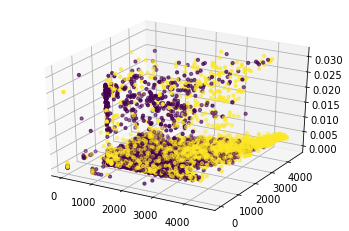

In [96]:
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0], X[:,1], X[:,2], c=Y, s=10)

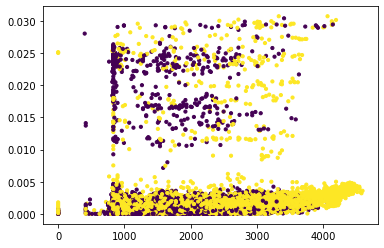

In [97]:
plt.figure()
plt.scatter((X[:,0] + X[:,1])/2, X[:,2], c=Y, s=10)

Как можно видеть из обеих графиков, между lps и показаниями тахометра нет взаимосвязи,
далее в качестве оси OX будет браться индекс, а кластеризация проводиться по одному признаку lps

In [98]:
X = df_X[['tachometer_start', 'tachometer_end', 'lps_abs']].to_numpy()
X = X[:, 2].reshape(-1, 1)
indicies = list(range(len(X)))

Используем разные методы кластеризации и визуализируем их результаты:

In [99]:
clustering_methods = {'KMeans': KMeans(n_clusters=2),
                      'Agglomerative':AgglomerativeClustering(n_clusters=2)}
Y_cluster = {}

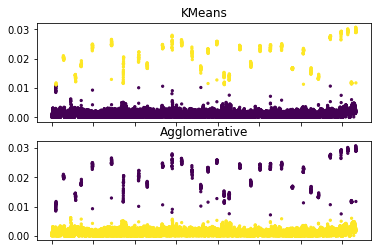

In [100]:
fig, ax = plt.subplots(len(clustering_methods), 1)
i = 0

for method_name, method in clustering_methods.items():
    Y_cluster[method_name] = method.fit_predict(X)

    ax[i].scatter(indicies, X, c=Y_cluster[method_name], s=5)
    ax[i].set_title(f'{method_name}')
    ax[i].set_xticklabels([])

    i+=1

Посмотрим, какие значения были помечены KMeans как сливы-заправки:

In [101]:
df_X['refuel_real'] = Y_cluster['KMeans']

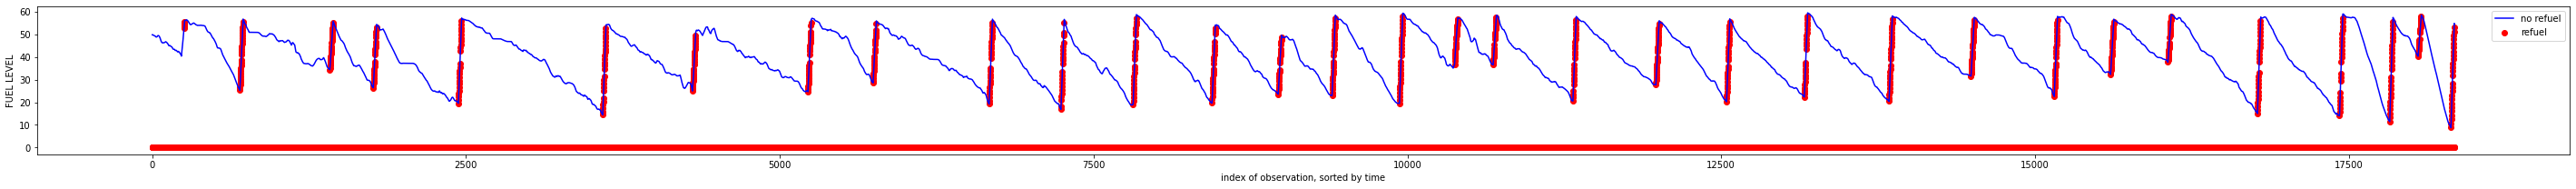

In [102]:

plt.figure(figsize=(50, 3))


plt.ylabel('FUEL LEVEL')
plt.xlabel('index of observation, sorted by time')

plt.plot(df_X.index, df_X['fuellevel_start'], color='blue', label='no refuel')
plt.scatter(df_X.index, df_X['fuellevel_start'] * (df_X['refuel_real']), color='red', label='refuel')
plt.legend()

plt.show()

Видим, что результаты неудовлетворительны. Проще помечать верхние 10 перцентилей как
сливы-заправки (больше похоже на правду):

In [103]:
quantile = df_X['lps_abs'].quantile(0.9)
df_X['refuel_real'] = 0
df_X['refuel_real'].loc[df_X['lps_abs'] > quantile] = 1

C:\conda\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


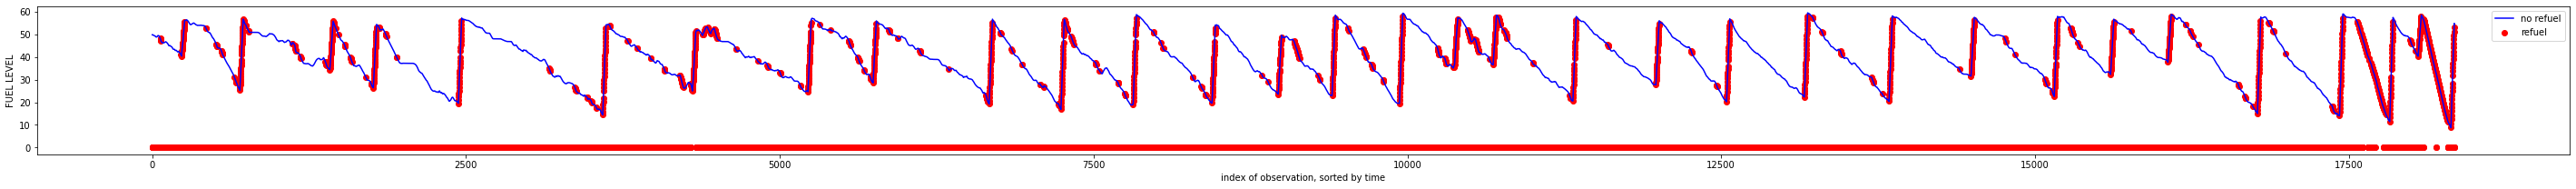

In [104]:
plt.figure(figsize=(50, 3))


plt.ylabel('FUEL LEVEL')
plt.xlabel('index of observation, sorted by time')

plt.plot(df_X.index, df_X['fuellevel_start'], color='blue', label='no refuel')
plt.scatter(df_X.index, df_X['fuellevel_start'] * (df_X['refuel_real']), color='red', label='refuel')
plt.legend()

plt.show()